# Dam detection

First iteration of dam detection using Sentinel 2 satellite images and GRanD dam dataset.
The code is inspired by work from a previous [hackathon](https://medium.com/@charlotteweil/can-we-locate-dams-from-space-2a796ac8c04b)


## TODO:

1. bridge separate label   nee
2. Extend data augmentations
11. gebruik aafke en Konrad om vragen te stellen

## Initialization 

In [3]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glob import glob
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Input, Lambda, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from itertools import repeat
from collections import Counter
from mpl_toolkits.axes_grid1 import ImageGrid
import re
from scripts.constants import SEED
from pprint import pprint
import tensorflow_probability as tfp
import os
import random as rd
from imgaug import augmenters as iaa
import pandas as pd
import seaborn as sns
import datetime
import shutil

from tfdeterminism import patch
patch()


TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0


In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## Loading data and creatin train/validation/test split

Load all of the TFRecords and define a train/validation/test split. The splitting can occur in a random, stratified, and completely balanced way. The latter means that the dataset is split in such a way that the validation set becomes balanced, despite the number of records per class, e.g. if there are 100 of class 0, and 200 of class 1, then a validation split of 0.1 means there will be 10 records per class in the validation set

In [5]:
# Locations of files in tensusers2
# Dams
train = glob('datasets/data/train/*.gz')
valid = glob('datasets/data/valid/*.gz')
test = glob('datasets/data/test/*.gz')

In [6]:
print(len(train), len(valid), len(test))

print(sum([len(train), len(valid), len(test)]))
print("class distribution GEE:", (3046 + 7299 + 3257) / (4316+13726+99000+8193))

877 35 737
1649
class distribution GEE: 0.10861180979758055


{'random': 561, 'forest': 72, 'bridges': 23, 'water_edges': 43, 'good': 30, 'grand': 5, 'drip': 3}
dams:  38
negatives  699


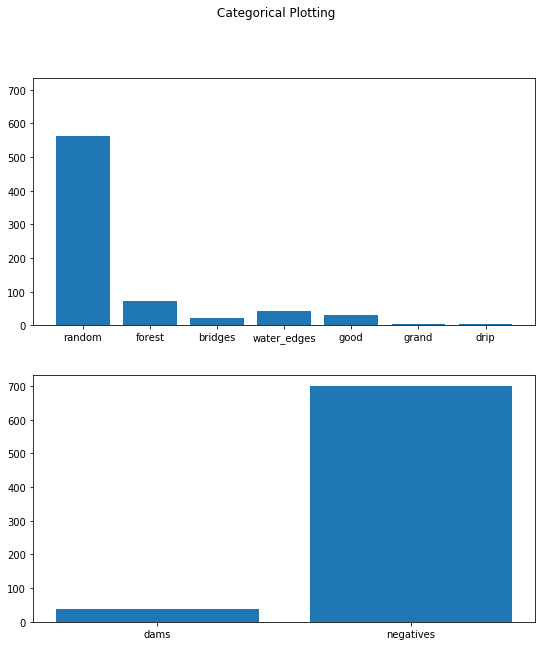

In [7]:
def find_match(data):
    string_lst = ['grand', 'good', 'drip', 'bridges', 'forest', 'random', 'water_edges']
    prog = re.compile(r"(?=("+'|'.join(string_lst)+r"))")
    results = np.array([prog.findall(x) for x in data]).flatten()
    names = Counter(results).keys() # equals to list(set(words))
    counts = Counter(results).values() # counts the elements' frequency
    
    zipbObj = zip(names, counts)
    # Create a dictionary from zip object
    distribution = dict(zipbObj)
    
    dams = distribution['grand'] + distribution['good'] + distribution['drip']
    negatives = sum(distribution[x] for x in ['bridges','forest','random','water_edges'])
    
    fig, axs = plt.subplots(2, 1, figsize=(9, 10), sharey=True)
    axs[0].bar(distribution.keys(), distribution.values())
    axs[1].bar(['dams', 'negatives'], [dams, negatives])
    fig.suptitle('Categorical Plotting')
    
    return distribution
    
z = find_match(test)
print(z)
print("dams: ", z['drip'] + z['good'] + z['grand'])
print("negatives ", z['bridges'] +  z['forest'] + z['water_edges'] +z['random'])


### TF parsing functions

The TF parsing functions. The parsing functions take the data inside of the TFRecords (one by one) and extract each example (an image separated into several loose arrays), label, and an index). These data can then further be pre-processed into actual N-Dimensional images and one hot labels.

In [54]:
# Tensorflow parse functions

# Parser function, extracted using a .map function

# In normal applications, I guess you would have a single function that does most of the heavy lifting
# but for illustrative purposes, multiple functions are used.
def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions
    
    Args:
        example_proto: a serialized example
        
    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        'AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        'NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
        'MNDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
        'AWEISH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
        'AWEINSH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
         #'index': tf.io.FixedLenFeature([1], dtype=tf.int64), # index
        'label': tf.io.FixedLenFeature([1], dtype=tf.float32) #label
    }
    
    return tf.io.parse_single_example(example_proto, featuresDict)


def stretch_image_colorspace(img):
    max_val = tf.reduce_max(img)
    return tf.cast(tf.divide(img, max_val), tf.float32)


#using a closure so we can add extra params to the map function from tf.Dataset
def parse_image(dims = [257, 257], channels = ['B4', 'B3', 'B2']):
    ''' Stack individual RGB bands into a N dimensional array
    The RGB bands are still separate 1D arrays in the TFRecords, combine them into a single 3D array
    
    Args:
        features: A dictionary with the features (RGB bands or other channels that need to be concatenated)
    '''
    
    # print("using the general image parsing function")
    def parse_image_fun(features):
        #channels = list(features.values())
        label = features['label']
        
        # Get the image channels, and NDWI/AVE channels separately
        # we cannot import them all at once since they need separate preprocessing steps
        img_chan = [features[x] for x in channels if x in ['B4', 'B3', 'B2']]
        ndwi_chan = [features[x] for x in channels if x in ['NDWI']]
        mndwi_chan = [features[x] for x in channels if x in ['MNDWI']]
        aweish_chan = [features[x] for x in channels if x in ['AWEISH']]
        aweinsh_chan = [features[x] for x in channels if x in ['AWEINSH']]
        ave_chan = [features[x] for x in channels if x in ['AVE']]
    
        
        # stack the individual arrays, remove all redundant dimensions of size 1, and transpose them into the right order
        # (batch size, H, W, channels)
        img = tf.transpose(tf.squeeze(tf.stack(img_chan)))
        
        # stretch color spaces of the RGB channels
        img = stretch_image_colorspace(img)
        
        if ndwi_chan:
            # further normalization?
            img = tf.concat([img, tf.transpose(ndwi_chan)], axis= 2)
            
        if mndwi_chan:
            img = tf.concat([img, tf.transpose(mndwi_chan)], axis= 2)
            
        if aweish_chan:
            img = tf.concat([img, tf.transpose(aweish_chan)], axis= 2)
            
        if aweinsh_chan:
            img = tf.concat([img, tf.transpose(aweinsh_chan)], axis= 2)
            
        if ave_chan:
            # normalization: https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V1_1
            ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
            img = tf.concat([img, tf.transpose(ave_chan)], axis= 2)
        
        # Additionally, resize the images to a desired size
        img = tf.image.resize(img, dims)
        return img, tf.reduce_max(tf.one_hot(tf.cast(label, dtype=tf.int32), 2, dtype=tf.int32), axis=0)
    
    return parse_image_fun


# label record iterator
def parse_label(features):
    labels = features['label']
    y,_, counts = tf.unique_with_counts(labels)
    return y, counts

def record_iterator(file_names, batch_size = 32):
    files = tf.data.Dataset.list_files(file_names, shuffle=False)
    dataset = tf.data.TFRecordDataset(files, compression_type='GZIP')
    dataset = dataset.map(parse_serialized_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda x: x['label'])
    dataset = dataset.batch(batch_size)
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    
    return dataset

## Record counter per dataset

In [57]:
# sort out the files ine ach dataset and group them

def record_counter(dataset):
    string_lst = ['grand', 'good', 'drip', 'bridges', 'forest', 'random', 'water_edges']
    string_dict = dict.fromkeys(string_lst)
    count_dict  = dict.fromkeys(string_lst)
    for category in string_lst:
        subset = []
        for x in dataset:
            if category in x:
                subset.append(x)
        string_dict[category]= subset

    # loop over all elements in string dict and count number of examples per category
    for key, values in string_dict.items():
        print("counting records for {}".format(key))
        counting_dataset = record_iterator(values, batch_size=64)

        counter = 0

        for x in counting_dataset.take(1):
            counter += len(x)

        count_dict[key] = counter
    return count_dict

counters = []
for key, value in dict(train=train, valid=valid, test=test).items():
    print("counting dataset {}".format(key))
    counters.append(record_counter(value))
    
    for sets in counters:
        pprint(sets)

counting dataset train
counting records for grand
counting records for good
counting records for drip
counting records for bridges
counting records for forest
counting records for random
counting records for water_edges
counting dataset valid
counting records for grand
counting records for good
counting records for drip
counting records for bridges
counting records for forest
counting records for random
counting records for water_edges
counting dataset test
counting records for grand
counting records for good
counting records for drip
counting records for bridges
counting records for forest
counting records for random
counting records for water_edges


In [67]:
print(counters)
datfr = pd.DataFrame.from_dict(counters).T
datfr.to_csv()
print(datfr)

#result = pd.concat([datfr, datfr], axis=1)
#print(result)

[{'grand': 64, 'good': 64, 'drip': 64, 'bridges': 64, 'forest': 64, 'random': 64, 'water_edges': 64}, {'grand': 64, 'good': 64, 'drip': 64, 'bridges': 64, 'forest': 64, 'random': 64, 'water_edges': 64}, {'grand': 64, 'good': 64, 'drip': 64, 'bridges': 64, 'forest': 64, 'random': 64, 'water_edges': 64}]
              0   1   2
grand        64  64  64
good         64  64  64
drip         64  64  64
bridges      64  64  64
forest       64  64  64
random       64  64  64
water_edges  64  64  64


## TF Sampling functions


In [9]:
def undersampling_filter(probs, class_target_prob, bridge_sep_label=False, undersampling_coef = 0.9):
    def wrapper(example):
        """
        Computes if given example is rejected or not.
        """
        label = example['label']
        label = tf.unstack(tf.cast(label, dtype = tf.int32))  

        dam_label = tf.constant(1)
        other_label = tf.constant(0)
        
        def other_fun(): return probs['other']
        def dam_fun(): return probs['dams']
        if bridge_sep_label:
            def bridge_fun(): return probs['bridges']
            def cond2(): return tf.cond(tf.equal(label[0], other_label), other_fun, bridge_fun)
            class_prob = tf.cond(tf.equal(label[0], dam_label), dam_fun, cond2)
        else:
            class_prob = tf.cond(tf.equal(label[0], dam_label), dam_fun, other_fun)

        prob_ratio = tf.cast(class_target_prob/class_prob, dtype=tf.float32)
        prob_ratio = prob_ratio ** undersampling_coef
        prob_ratio = tf.minimum(prob_ratio, 1.0)

        acceptance = tf.less_equal(tf.random_uniform([], dtype=tf.float32), prob_ratio)
        # predicate must return a scalar boolean tensor
        return acceptance

    return wrapper

def oversampling_filter(probs, class_target_prob, bridge_sep_label=False, oversampling_coef =0.9):
    
    def wrapper(example):
        """
        Computes if given example is rejected or not.
        """
        label = example['label']
        label = tf.unstack(tf.cast(label, dtype = tf.int32))  

        dam_label = tf.constant(1)
        other_label = tf.constant(0)
        
        def other_fun(): return probs['other']
        def dam_fun(): return probs['dams']
        if bridge_sep_label:
            def bridge_fun(): return probs['bridges']
            def cond2(): return tf.cond(tf.equal(label[0], other_label), other_fun, bridge_fun)
            class_prob = tf.cond(tf.equal(label[0], dam_label), dam_fun, cond2)
        else:
            class_prob = tf.cond(tf.equal(label[0], dam_label), dam_fun, other_fun)
        
        prob_ratio = tf.cast(class_target_prob/class_prob, dtype=tf.float32)
        # soften ratio is oversampling_coef==0 we recover original distribution
        prob_ratio = prob_ratio ** oversampling_coef 
        # for classes with probability higher than class_target_prob we
        # want to return 1
        prob_ratio = tf.maximum(prob_ratio, 1) 
        print(prob_ratio)
        # for low probability classes this number will be very large
        repeat_count = tf.floor(prob_ratio)
        # prob_ratio can be e.g 1.9 which means that there is still 90%
        # of change that we should return 2 instead of 1
        repeat_residual = prob_ratio - repeat_count # a number between 0-1
        residual_acceptance = tf.less_equal(
                            tf.random_uniform([], dtype=tf.float32), repeat_residual
        )

        residual_acceptance = tf.cast(residual_acceptance, tf.int64)
        repeat_count = tf.cast(repeat_count, dtype=tf.int64)

        return repeat_count + residual_acceptance

    return wrapper

## Data exploration
This section will cover some basic data exploration. The idea is to check whether we can get a handle on the TFRecord format, see how it works, and if the data itself has proper characteristics. To do this we can view several of the images as examples, count the label distribution to make the distinction whether we are dealing with a balanced or imbalanced dataset, and view several augmentations.   

We will start by simply loading the dataset and printing some basic information about the records inside of the TFRecord datafile.

For simplicity, we will only cover the training data for now. When we are going to train a neural network, we will also consider the validation and testing datasets
.

The code below loads a list of TFRecords defined in ```x_train``` into a TFRecordDataset, which is a very useful handle for manipulating TFRecord contents. The most important functionality is the ```map``` function, which maps a function over several workers. We have defined the function for record parsing and turning the example proto into a proper image above already. All we have to do now is give the user-defined function to the map call, and we are all set.

We can also see why the function ```parse_image``` was defined as a closure above. Typically, a map function does not accept multiple parameters from user-defined functions, only the function itself. To allow for some further flexibility within ```parse_image```, we can define a closure and then call it with the desired arguments before passing it on to the ```TFRecordDataset.map() ```function 

We define two different parsing functions. The only difference between them is that the boolean for ```stretch_colorspace``` is set to either true or false. The reason for this difference becomes clear when we view the example patches in the next section.

In [20]:
# rd.shuffle(train)

# good for visuals
# drip 29
# good 202
# random_20-042
train_data = tf.data.TFRecordDataset(train, compression_type='GZIP')

# image parsing function
parsed_record = train_data.map(parse_serialized_example)
# returns the image and label
parsed_image = parsed_record.map(parse_image([257, 257], 
                                 channels = ['B4', 'B3', 'B2', 'AVE', 'NDWI', 'MNDWI', 'AWEISH', 'AWEINSH']))

for f in augmentations:
    parsed_image = parsed_image.map(lambda x,y: tf.cond(tf.random_uniform([], 0, 1) > 0.75, lambda: (f(x),y), lambda: (x, y)), num_parallel_calls=4)

### Example patches
The best way to view for possible inconsistencies in the dataset or the pipeline is by viewing the images firsthand. This is exactly what the code below does. The nice thing about the TFRecordDataset is that they are not only iterable, but they can also be turned into an iterator. This way, we can simple call upon the ```next()``` functionality that iterators have.

One of the problems found early on through exploratory analysis was that the images were extremely dark (RGB unstretched). The reason for this is that the colorspace had to be stretched: inspecting the values of the B2 through B4 bands manually, we found that the values were mostly in the range of $[0, 0.2]$. Since Python expects a range of $[0,1]$ or $[0, 255]$, we decided to map the values in the former range. The exact way on how to do this is defined in the ```stretch_image_colorspace``` function. It basically divides all values by the maximum number in the channel array. The images with stretched colorspace values are shown in the second column.

The third and fourth columns show the NDWI and AVE, respectively.

datasets/data/train/drip-015.gz


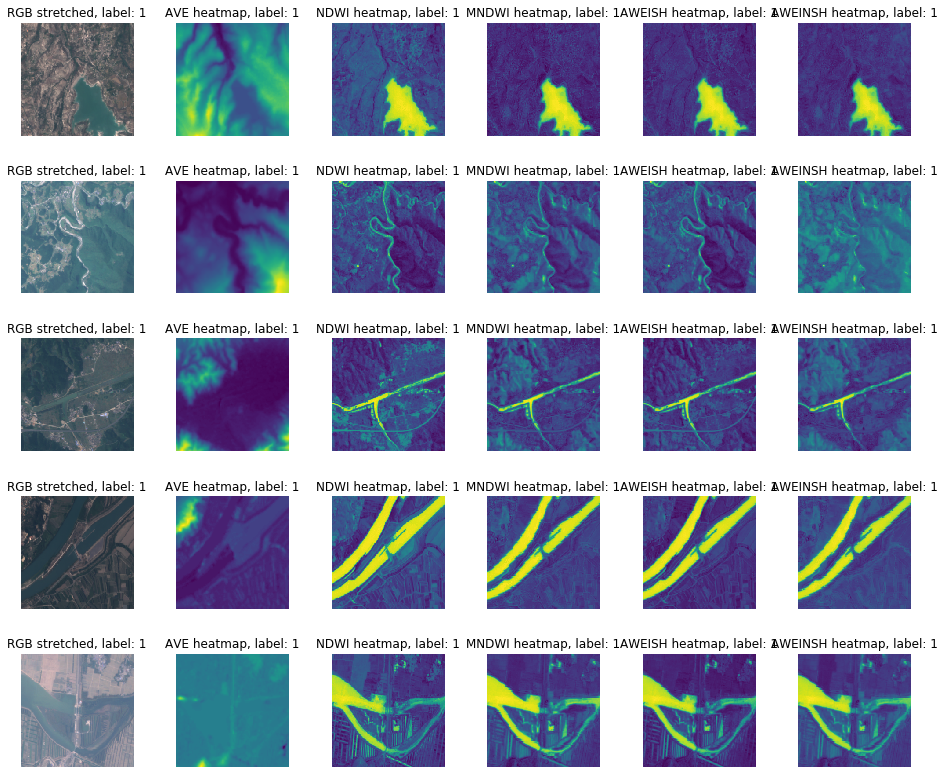

In [21]:
# ADD AVE/NDWI heatmaps?
columns = 6
rows = 5
print(train[0])
fig = plt.figure(figsize=(columns+8, rows+5))
gs = gridspec.GridSpec(rows, columns,
         wspace=0.2, hspace=0.4, 
         top=1.2-0.5/(rows + 1), bottom=0.5/(rows+1), 
         left=0.5/(columns+1), right=1-0.2/(columns+1)) 

parse_iter = iter(parsed_image)

for j in range(rows):
    image_features, label = parse_iter.next()

    
    #good example: stretched colorspace
    #uint8 only stores 256 values :/
    ax = plt.subplot(gs[j,0])
    ax.set_title("RGB stretched, label: {}".format(np.argmax(label.numpy())))
    ax.imshow(image_features[:,:,0:3])
    plt.axis('off')
    
    ax = plt.subplot(gs[j,1])
    ax.set_title("AVE heatmap, label: {}".format(np.argmax(label.numpy())))
    im =ax.imshow(image_features[:,:,7], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    
    ax = plt.subplot(gs[j,2])
    ax.set_title("NDWI heatmap, label: {}".format(np.argmax(label.numpy())))
    im = ax.imshow(image_features[:,:,3], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    
    ax = plt.subplot(gs[j,3])
    ax.set_title("MNDWI heatmap, label: {}".format(np.argmax(label.numpy())))
    im = ax.imshow(image_features[:,:,4], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    
    ax = plt.subplot(gs[j,4])
    ax.set_title("AWEISH heatmap, label: {}".format(np.argmax(label.numpy())))
    im = ax.imshow(image_features[:,:,5], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    
    ax = plt.subplot(gs[j,5])
    ax.set_title("AWEINSH heatmap, label: {}".format(np.argmax(label.numpy())))
    im = ax.imshow(image_features[:,:,6], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')

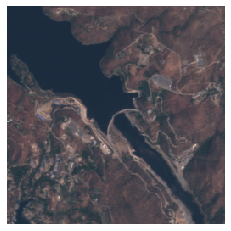

In [80]:
for img, label in parsed_image.take(72):
    plt.imshow(img[:,:,0:3])
    plt.axis('off')

## Image augmentations

Besides showing normal images, we can also show augmented images. At the top we defined several augmentation functions in tensorflow. These augmentations can be viewed as well using the code below. It is designed in such a way that individual augmentations are shown in order to display the effect of a single augmentation.

We define two different classes of augmentations. The first class features augmentations that are channel invariant. This means that they can be sensibly applied on any channel, or in some cases have to be applied on every channel to make sense. Examples of such augmentations are the flip and rotate functions, since if one channel is not rotated and the others are, then the spatial information no longer aligns. 

The second class of augmentations are transformations that can only be applied to a subset of layers, in this case the RGB channels. Examples of these transformations are the color augmentations. Naturally, such mappings only work on the color channels themselves and have no meaning when applied to any other dimension, such as NDWI. In fact, it would result in an error.

In [11]:
def plot_images(dataset, n_images, samples_per_image):
    columns = samples_per_image
    rows = n_images * 3

    
    def plot_fun():
        fig = plt.figure(figsize=(columns+6, rows+8))
        gs = gridspec.GridSpec(rows, columns,
                               wspace=0, hspace=0.0, 
                               top=1.-0.5/(rows + 1), bottom=0.5/(rows+1), 
                               left=0.5/(columns+1), right=1-0.5/(columns+1)) 

        i=0
        for images in dataset.repeat(samples_per_image).batch(n_images):
            k = 0
            #print("images ", images)
            for j in range(0, n_images):
                #print(i)
                #print(j)
                ax = plt.subplot(gs[j*3,i])
                ax.imshow(np.squeeze(images[j,:,:,0:3]))
                plt.axis('off')
                ax = plt.subplot(gs[j*3+1, i])
                ax.imshow(images[j,:,:,3], cmap= 'viridis', interpolation='nearest')
                plt.axis('off')
                ax = plt.subplot(gs[j*3+2, i])
                ax.imshow(images[j,:,:,4], cmap= 'gray', interpolation='nearest')
                plt.axis('off')
            i+=1
    plot_fun()


The augmentations below can be changed into any function specified at the very top. Some of these functions operatore on all of the channels, whereas others only make sense when they are applied to the RGB channels, such as shifting the color channels themselves to hsv.

Below the augmentations are plotted in pairs of 3 rows per image. The first row shows the RGB bands, each second row shows the NDWI, and each third row shows the elevation (AVE). By experimenting with the augmentations one can see the ffect of each augmentation on the different channels

In [12]:
# get right order: use some of, any all, sometimes, oneof, affine, etc
# use shears

# THE PARAMETERS VALUES FOR THESE AUGMENTATIONS ARE ONLY FOR SHOW, 
# THESE ARE NOT THE ACTUAL PARAMETERS DEFINED IN AUGMENTATIONS.PY

import imgaug as ia
ia.seed(SEED)

def apply_augmentation(img):
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    
    
    # channel invariant augmentations
    seq = iaa.Sequential([
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        iaa.Flipud(0.5),
        sometimes(iaa.Rot90((1, 3)))
    ], random_order=True)
    
    # RGB dependent augmentations
    seq2 = sometimes(
            iaa.SomeOf((1,4),[
                iaa.AddToHue((-8,8)),
                iaa.AddToSaturation((-15,15)),
                iaa.Multiply((0.85, 1.25)),
                iaa.LinearContrast((0.85, 1.4))
                ], random_order=True)
    )
    
    img = seq(image=img)
    img2 = np.array(img[:,:,0:3] * 255, dtype=np.uint8)
    img2 = seq2(image=img2)
    img2 = np.array(img2/255, dtype=np.float32)
    img[:,:,0:3] = img2
    #print(img)
    return img
    

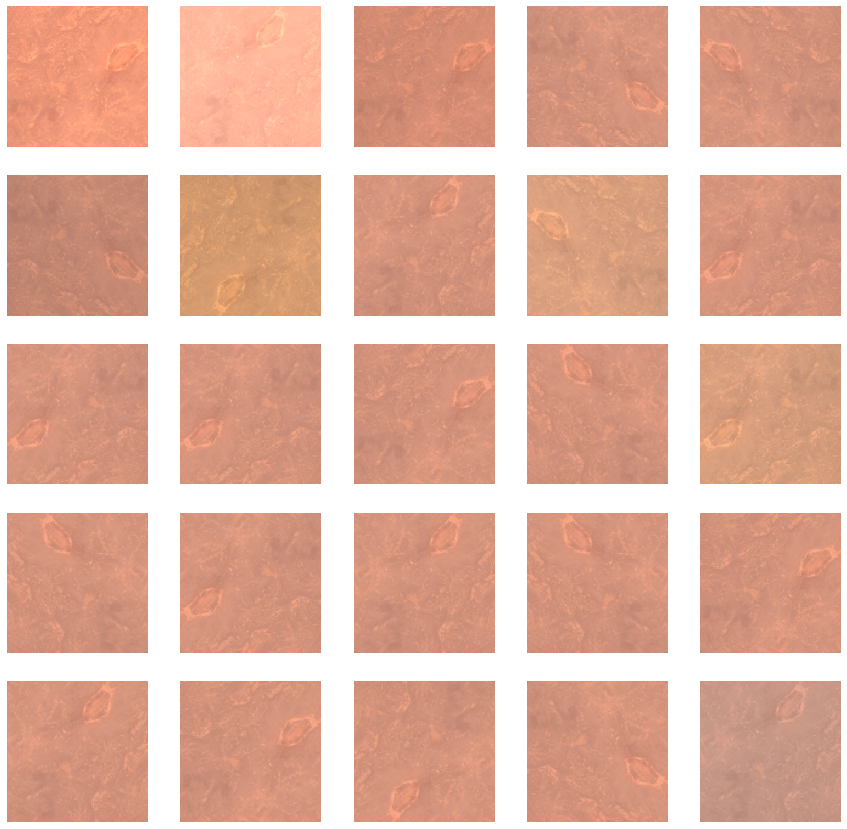

In [13]:
train_data = tf.data.TFRecordDataset(train[0], compression_type='GZIP')
n_images = 6

# image parsing function
parsed_record = train_data.map(parse_serialized_example)
# returns the image and label
parsed_image = parsed_record.map(parse_image([257, 257],
                                             channels=['B4', 'B3', 'B2', 'NDWI', 'AVE']))

# DO NOT REMOVE
# replace lambda x,y: f(x) with any augmentation function f() above, or self defined
#parsed_image = parsed_image.map(lambda x,y: blur(x, stddev=3.0))
#plot_images(parsed_image.take(n_images), n_images, 4)


parsed_image_aug = parsed_image.map(lambda x,y: 
                                (tf.numpy_function(apply_augmentation,
                                                  [x],
                                                  tf.float32),y))


image_iterator = iter(parsed_image_aug.take(1).repeat(25))
fig, axes = plt.subplots(5, 5)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(5):
        #print(augment)
        img, label = next(image_iterator)
        img = img.numpy()
        axes[j, i].imshow(img[:,:,0:3])
        axes[j, i].axis('off')
              
plt.show()

datasets/data/train/random_20-042.gz


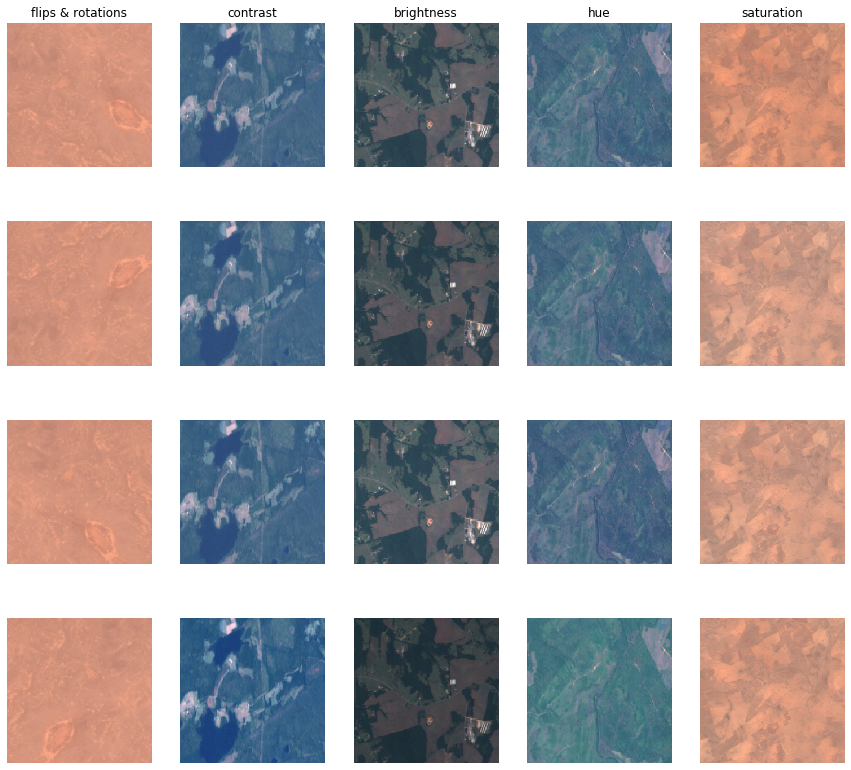

In [14]:
# image augmentations
# good 202 is excellent :o

# THE PARAMETERS FOR THESE AUGMENTATIONS ARE ONLY FOR SHOW, NOT THE ACTUAL PARAMETERS DEFINED IN AUGMENTATIONS.PY

print(train[0])
flips_aug = iaa.Sequential([iaa.Fliplr(0.5),
                            iaa.Flipud(0.5),
                            iaa.Rot90((0,3))])

contrast_aug = iaa.Sequential([iaa.LinearContrast((0.85, 1.4))])
brightness_aug = iaa.Sequential([iaa.Multiply((0.80, 1.25))])

hue_aug = iaa.Sequential([iaa.AddToHue((-8, 8))]) 
sat_aug = iaa.Sequential([iaa.AddToSaturation((-20,20))]) 


augmenters = [flips_aug, contrast_aug, brightness_aug, hue_aug, sat_aug]
img_iterator = iter(parsed_image.take(5).repeat(20))


fig, axes = plt.subplots(4, 5)
fig.set_figheight(14)
fig.set_figwidth(15)
for i in range(5):
    augment = augmenters[i]
    img, label = next(img_iterator)
    img = np.array(img * 255, dtype=np.uint8)
    for j in range(4):        
        img_aug = augment(image=img[:,:,0:3])
        axes[j, i].imshow(img_aug[:,:,0:3])
        axes[j, i].axis('off')
        
axes[0,0].title.set_text('flips & rotations')
axes[0,1].title.set_text('contrast')
axes[0,2].title.set_text('brightness')
axes[0,3].title.set_text('hue')
axes[0,4].title.set_text('saturation')
plt.show()

### Record counter
The code below is a simple function to count the number of records inside of the TFRecord files. The idea is a basic reduce function that aggregates the unique labels and their counts

WARNING: THIS CODE ONLY SHOWS THE RIGHT COUNTS PER LABEL IF THERE ARE ONLY TWO LABELS. IF BRIDGES HAS A SEPARATE LABEL, THEN ONLY THE TOTAL COUNT IS CORRECT

In [14]:
# the code state+value reads like a recursion
# the state gets saved and incremented by value (similar to a for loop)
# state by default initializes to 0
# value contains the return argument in the mapped counted labels function
# reduce(np.int64(0), lambda state, value: state + value)

# THIS FUNCTION DOES NOT COMPUTE THE RIGHT NUMBER OF LABEL 1 IF BRIDGES HAS LABEL 2
# ONLY USE THIS WHEN BRIDGES HAS LABEL 0
'''
def count_labels(parser):
    cnt = parser.reduce(np.int64(0), lambda x, y: x + y)
    print("total count is {}".format(cnt[1]))
    print("Total number of examples with label 1 is {}".format(cnt[0]))

parsed_label = parsed_record.map(parse_label, 2)
count_labels(parsed_label)


iterator = iter(parsed_image)

i = 0
while True:
    i +=1
    try:
        iterator.next()
    except tf.errors.InvalidArgumentError:
        print("found error at iteration {}".format(i))
        continue
    except StopIteration:
        break
print("counted {} examples".format(i))


newdirs = [data_path + x for x in ['/train' ,'/validation', '/test']]
dirs_files = [(x,y) for x,y in [(newdirs[0], x_train), (newdirs[1], x_val), (newdirs[2], x_test)]]
'''

'\ndef count_labels(parser):\n    cnt = parser.reduce(np.int64(0), lambda x, y: x + y)\n    print("total count is {}".format(cnt[1]))\n    print("Total number of examples with label 1 is {}".format(cnt[0]))\n\nparsed_label = parsed_record.map(parse_label, 2)\ncount_labels(parsed_label)\n\n\niterator = iter(parsed_image)\n\ni = 0\nwhile True:\n    i +=1\n    try:\n        iterator.next()\n    except tf.errors.InvalidArgumentError:\n        print("found error at iteration {}".format(i))\n        continue\n    except StopIteration:\n        break\nprint("counted {} examples".format(i))\n\n\nnewdirs = [data_path + x for x in [\'/train\' ,\'/validation\', \'/test\']]\ndirs_files = [(x,y) for x,y in [(newdirs[0], x_train), (newdirs[1], x_val), (newdirs[2], x_test)]]\n'

## Training a Neural network 
We will now illustrate on how to construct a basic neural network using the TFRecord pipeline. We can use the tf.keras api to easily create a keras-like neural network model using generators, constructed from the TFRecords. 
We can use many of the previously defined functions here. We start by first randomizing our dataset, after which we can create/compile our model and train it.


# Under/Oversampling procedures (not in yet in training)

In [15]:
from collections import defaultdict, Counter
import pandas

In [17]:
#print(x_train)
string_lst = ['grand', 'other', 'bridges', 'good']
prog = re.compile(r"(?=("+'|'.join(string_lst)+r"))")
results = Counter(np.array([prog.findall(x) for x in x_train]).flatten())

num_classes = 2

class_counts = results
print(class_counts)
total_counts = sum(class_counts.values())

probs = {}

probs['dams'] = (class_counts['grand'] + class_counts['good']) / total_counts
if num_classes == 2:
    # dams and other (including bridges)
    probs['other'] =(class_counts['other'] + class_counts['bridges'] ) / total_counts
elif num_classes ==3:
    # bridges as separate classifier
    probs['bridges'] = class_counts['bridges'] / total_counts
    probs['other'] = class_counts['other'] / total_counts
    
print(probs)
    
df = pandas.DataFrame()
df['class_prob'] = pandas.DataFrame.from_dict(class_counts, orient='index')[0]
df['uniform'] = 1
df = df/df.sum(0)
df.sort_index().plot(kind='bar', title='frequencies before sampling')

NameError: name 'x_train' is not defined

### TFRecord randomization
Before diving into running models with the TFRecord and Tensorflow pipeline, it is good to understand how data from the TFRecord dataset flows through a model. Essentially the data in the records are still in sorted order: first the examples with label 1 are on the top, and the examples with label 0 are at the bottom.

The backpropagation algorithm works best if the (mini)batches examples are in a shuffled and random order. This way, a diverse set of examples are shown to the neural network in each pass. For this reason, shuffling the data is a good idea to improve training speed, which means labels should occur randomly in each batch, e.g. (1,1,0,0,0,0,0,1,0,1,1).

Secondly, we do not want to show the exact same order of the data in each iteration, but rather mix it up so that neural networks sees different combinations of possibly the same data. In order to do this, we must randomize our TFRecord shards. Both the shards themselves, as well as their contents. This is done in the code below. 

An additional notebook is also available that dives deeper into how the randomization process in tensorflow actually works called test_randomization.py. It is inspired by another notebook that can be found [here](https://colab.research.google.com/github/christianmerkwirth/colabs/blob/master/Understanding_Randomization_in_TF_Datasets.ipynb#scrollTo=pS0ihDFTd1uI)

Keep in mind that we basically need 2 generators, one for the training dataset, which needs randomization, and one for the validation/testing data, which does not need randomization.

In [15]:
def random(file_names, target_size, buffer_size, channels, augmentations=[]):
    files = tf.data.Dataset.list_files(file_names, shuffle=None, seed=SEED)
    shards = files.shuffle(buffer_size=15)
    
    dataset = shards.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type='GZIP'), 
                                cycle_length=len(file_names), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=buffer_size)

    #dataset = dataset.repeat(4)
    dataset = dataset.map(parse_serialized_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_image(dims = target_size, channels = channels), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # AUGMENTATIONS
    
    # BATCHING
    
    dataset = dataset.batch(32)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    return dataset

def validate(file_names, target_size, channels):
    files = tf.data.Dataset.list_files(file_names, shuffle=False)
    dataset = tf.data.TFRecordDataset(files, compression_type='GZIP')
    dataset = dataset.map(parse_serialized_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_image(dims = target_size, channels = channels),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32)
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    
    return dataset


## Model training
The previous sections have treated basic handling of TFRecords and data exploration. Now we want to focus on main goal of this notebook, which is creating a classifier that detects dams from satellite images. 

In [21]:
# Load the TFRecord file
# was 50, 50
TARGET_SIZE= [257, 257]
BUFFER_SIZE= 500
CHANNELS = ['B4', 'B3', 'B2']
BATCH_SIZE = 1


print(np.sort(valid)[0:12])
train_dataset = random(train[0:10], TARGET_SIZE, BUFFER_SIZE, CHANNELS )
val_dataset = validate(np.sort(valid)[0:12], TARGET_SIZE, CHANNELS)
test_dataset = validate(test[0:2], TARGET_SIZE, CHANNELS)


def create_label_csv(dataset, fname):
    print("creating label list for data set")
    start_time = datetime.datetime.now()
    print("start time: {}".format(start_time))
    labels = [label for img,label in dataset]
    labels = [np.argmax(item) for sublist in labels for item in sublist]
    labels = np.array(labels)
    print("finished creating list")
    end_time = datetime.datetime.now()
    print("end time is: {}".format(end_time))
    elapsed = end_time - start_time
    print("Elapsed time: {}".format(elapsed))
    df = pd.DataFrame({'label': labels})
    df.to_csv(fname ,index=False)
    
if not os.path.exists('datasets/data/valid/val_labels.csv'):
    print(os.path.exists('datasets/data/valid/val_labels.csv'))
    create_label_csv(val_dataset,'datasets/data/valid/val_labels.csv')
else:
    print("validation labels csv exist")
    
if not os.path.exists('datasets/data/test/test_labels.csv'):
    create_label_csv(test_dataset,'datasets/data/test/test_labels.csv')
else:
    print("test labels csv exist")
    


['datasets/data/valid/bridges-011.gz' 'datasets/data/valid/bridges-015.gz'
 'datasets/data/valid/drip-013.gz' 'datasets/data/valid/forest-001.gz'
 'datasets/data/valid/forest-031.gz' 'datasets/data/valid/forest-071.gz'
 'datasets/data/valid/good-189.gz' 'datasets/data/valid/good-292.gz'
 'datasets/data/valid/grand-027.gz' 'datasets/data/valid/random_10-002.gz'
 'datasets/data/valid/random_10-009.gz'
 'datasets/data/valid/random_10-030.gz']
validation labels csv exist
test labels csv exist


In [22]:
# doodle network
inputs = Input(shape=(257, 257, 3), name='new_input')

x = Conv2D(32, (3,3))(inputs)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D()(x)

x = Conv2D(32, (3,3))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D()(x)

x = Conv2D(32, (3,3))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D()(x)


x = Conv2D(32, (3,3))(x)
x = Flatten()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])


In [23]:
# model callbacks
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
from tensorflow.keras.callbacks import Callback
import seaborn as sns
import io
import tensorflow.contrib.summary as tfsum


# TODO:
# Metrics: 
# to tensorboard
# test weights

# Confusion mat
# Turn into proper callback class

# model file:
# Test darknet 19 if it needs flatten (predictions)
# argparse
# run everything :)

class Metrics(Callback):
    def __init__(self, validation_data, labels, save_best, save_name, writer):
        super().__init__()
        self._validation_data = validation_data
        self._labels = labels
        self._save_best = save_best
        self._save_name = save_name
        self._bestf1 = 0
        self._file_writer = writer
        self._classes = [0,1]
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax((np.asarray(self.model.predict(self._validation_data))).round(), axis=1)
        _val_f1 = f1_score(self._labels, val_predict)
        _val_recall = recall_score(self._labels, val_predict)
        _val_precision = precision_score(self._labels, val_predict)
        #self.val_f1s.append(_val_f1)
        #self.val_recalls.append(_val_recall)
        #self.val_precisions.append(_val_precision)
        print('\n')
        print(' - val precision: {:.4f} - val recall: {:.4f} - val f1: {:.4f}'.format(_val_precision,
                                                                                      _val_recall,
                                                                                      _val_f1))
        
        # update best weights
        if self._save_best and self._save_name is not None and _val_f1 > self._bestf1:
            print("f1 improved from {} to {}, saving model to {}.".format(self._bestf1, _val_f1, self._save_name))
            self._bestf1 = _val_f1
            self.model.save(self._save_name)
            
        # write a confusion matrix to the tensorboard
        con_mat = tf.math.confusion_matrix(np.squeeze(self._labels),
                                           val_predict).numpy()

        con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

        con_mat_df = pd.DataFrame(con_mat_norm,
                         index = self._classes, 
                         columns = self._classes)

        figure = plt.figure(figsize=(8, 8))
        sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        buf = io.BytesIO()
        plt.savefig(buf, format='png')

        plt.close(figure)
        buf.seek(0)
        image = tf.image.decode_png(buf.getvalue(), channels=4)

        image = tf.expand_dims(image, 0)
        
        with self._file_writer.as_default(), tf.contrib.summary.always_record_summaries():
            tf.contrib.summary.scalar('val_f1', _val_f1, step=epoch)
            tf.contrib.summary.scalar('val_precision', _val_precision, step=epoch)
            tf.contrib.summary.scalar('val_recall', _val_recall, step=epoch)
            tf.compat.v2.summary.image("Confusion Matrix", image, step=epoch)

In [24]:
labels = pd.read_csv('datasets/data/valid/val_labels.csv')
labels = np.squeeze(labels.to_numpy())[0:1200]
print(labels)

[0 0 0 ... 0 0 0]


In [25]:
log_dir = "logs/fit" + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

file_writer = tfsum.create_file_writer(log_dir)
#file_writer.set_as_default()
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

f1_metric = Metrics(val_dataset, 
                    labels, 
                    save_best=True, save_name='best_f1.h5', writer=file_writer)


model.summary()
model.fit(train_dataset.repeat(),
          epochs = 2,
          validation_data=val_dataset,
          steps_per_epoch = 500,
          callbacks = [tensorboard_cb, f1_metric])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
new_input (InputLayer)       [(None, 257, 257, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 255, 255, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 253, 253, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 32)        0   

In [29]:
import gc
model = None
del model
K.clear_session()
tf.compat.v1.reset_default_graph() # TF graph isn't same as Keras graph
gc.collect()

176

In [28]:
gc.collect()

0

In [ ]:
preds = model.predict(test_dataset.take(1))    
columns = 1
rows = 32

fig = plt.figure(figsize=(columns+8, rows+6))
gs = gridspec.GridSpec(rows, columns,
         wspace=0.0, hspace=0.4, 
         top=1.2-0.5/(rows + 1), bottom=0.5/(rows+1), 
         left=0.5/(columns+1), right=1-0.5/(columns+1)) 
    
for img, label in test_dataset.take(1):
    for j in range(0,10):
        # bad example: too dark
        ax = plt.subplot(gs[j,0])
        ax.set_title("test img, label: {}, dam prob: {}".format(np.argmax(label[j,:]), np.squeeze(preds[j])[1]))
        ax.imshow(img[j,:,:,0:3])
        plt.axis('off')

In [ ]:
results = x.evaluate(test_dataset)
print("results are", results)

In [ ]:
preds = x.predict(test_dataset)
#labels = [label for [sublist, labellist] in test_dataset for [img,label] in labellist]

labels = [label for img,label in test_dataset]
labels = [np.argmax(item.numpy()) for sublist in labels for item in sublist]
labels = np.array(labels)

conf_mat = tf.confusion_matrix(labels, np.argmax(preds, axis=1))
print(conf_mat.numpy())

In [ ]:
# Testing how well this goes with the flatten operator (and without)
#test_model = create_model(train_model = False)
#test_model.load_weights('checkpoints/model-fcn-2019_10_15_19_54_54.hdf5')

#preds = test_model.predict(test_dataset.take(1))    
#print(np.squeeze(preds)[0,:,:,:])

# TESTING ZONE: USING UP CONVOLUTIONS WITH ONLY CLASSIFICATION LABELS

## LOG 10/10/2019
FROM THE TF PARSE FILE   
TODO: ADD TARGET SIZE AS A VARIABLE PARAMETER                        DONE
TODO: ADD BATCH SIZE                                                 DONE
TODO: CONNECTION WITH experiment.py and omniboard                    DONE
TODO: fully integrate with sacred/omniboard and experiment.py        DONE
TODO: CONFIG OPTION EXTEND TO BRIDGES (switch from 2 to 3 labels)    
TODO: REPLACE DEPRECATED NAMES									   DONE

 TODO: PARAMETERS IN OMNIBOARD: BATCH_SIZE, TARGET_SIZE, lr onplateau DONE

 PREPROCESSING AND AUGMENTATION
 TODO: AUGMENTATION PIPELINE                                          DONE              
 TODO: PREPROCESSING (normalize image to [0,1])                       DONE
 TODO: NORMALIZATION/STANDARDIZATION FOR NDWI AND ELEVATION
 TODO: SET VALIDATION AND STEPS PER EPOCHS                            DONE
TODO: USE SUBSET OF DATA                                             DONE

## LOG 03/10/2019
- Data augmentations created (notebook)
- Data augmentation pipeline implemented in spyder
- Moved data to scratch (load_data.py not adjusted for this)!
- Channel visualization in notebook
- Various optimization: Tested map after batch for optimization. The result is that this did not improve the training times. Also added prefetch function

## LOG 23/09/2019
Some experiment framework edits. None of these involve editing the notebook
- Created MongoDB instance for Sacred 
- Copied/edited sacred pipeline from ismi (experiment.py)
- Created omniboard instance at [heroku](https://omniboardstep.herokuapp.com/). Since building it on the server did not work, a Docker image was successfully used.
- Tested the sacred/omniboard pipeline with simple networks.
- Made it so that hyperparameters/options are logged and easily changed

## LOG 09/09/2019
- Extracted improved dataset from GEE
- Reading up on Tensorflow records...
- Editing TFRFilter


## LOG 02/09/2019
- Created data pipeline in notebook
- Basic data visualization (RGB)
- Basic pipeline in spyder
- Move project to the Ponyland
   

## LOG 26/08/2019
- Created notebook and todo list



## TODO
Current to do list is cut into several aspect, namely at the data (implementation), implementation, and reporting areas.
The current version uses the following named data assets (on my personal google account).
1. GRanD_dams_v1_3: A shapefile with near locations of large dams, according to the GRanD v1.3. dataset, which can be found [here](http://globaldamwatch.org/grand/)
2. NoDams: coordinates of locations without dams, but near water bodies. 


### Data

The current dataset as of 23/08/2019 (Google Drive) contains the GRanD v 1.3. dams examples that serve as the positive labels for dam examples, as well as negative examples with samples that are located near water bodies. 
The following things come to mind to extend the dataset:

1. ***Extend non dam examples***: Adding more negative examples such as bridges, more locations near or in water bodies, dense forests, shiny roads, etc. 
2. ***Extend dam examples***: Adding more dam examples can be done by adding the locations of smaller dams, which can be found [here](http://globaldamwatch.org/).
3. ***NDVI data analysis***: A possible way to determine the effect of placing a dam on biodiversity could be to calculate the NDVI in the region before and after a dam was placed, and determine the difference in trend.
4. ***Segmentation/ gold standard labelling***: Several tools exists to create segmentation data which is more valuable. The downside is that it is a lot of manual labour, and multiple people are needed to create annotator agreement examples are [labelbox](https://labelbox.com/), which is a hosted service, or several labelling programs that can be run on your own server and are similar to labelbox, such as [labelme](https://github.com/wkentaro/labelme) or [labeltool](https://github.com/Slava/label-tool). 
5. ***Add watermask data***: Watermasks can help in dam detection as a simple heuristic: if there is no water, there is no dam
6. ~~***Move data to scratch***: the scratch folder on the individual pony's is faster than tensusers~~
7. ***Testing regions***: extract several large testing regions to be evaluated per DICE scores


### Experimentation pipeline
1. ~~***Sacred***: logging database for the experiments.~~
2. ~~***Omniboard***: Dashboard for the sacred environment.~~


### Implementation

The current implementation consists mainly of an experimental pipeline which has to be extended and optimized. The main focus lies on efficient data handling, an augmentation pipeline, reproducibility, and (readable) result creation in the form of graphs and metrics from which inference can be made.

1. ~~***Move data and scripts to server (Ponyland cluster)*** : self explanatory, make use of the more powerful GPU than on my local machine.~~
2. ~~***Data augmentation pipeline*** :The current implementation does not have any data augmentation. The fact that we are working with TFRecord can make it more difficult to work with data augmentations since no generators with predefined transformation are readily available.~~
3. ~~***data preprocessing***: along with data augmentation, the data needs basic preprocessing such as color stretching and normalization, which is a standard method in deep learning~~
4. ~~***Create abstract tuning/model pipeline***: Different classiers and neural network architectures will be tried and finetuned to find the best result. In order to prevent writing a lot of repeated code in many different files, a pipeline will be made from which models can be defined, finetuned, and executed.~~

5. ~~***Optimize TF pipeline***: test order of map/batch and prefetch commands: result: parse_example and batch before map did not improve~~
6. ***FCNN***: main experiment architecture
7. ***Bridge as seperate labels***: test whether adding bridges as a separate label helps training
8. ~~***Finetuning/flexibility pipeline***: Add functionality for changing parameters/options easily within the sacred/omniboard framework~~
9. Set steps per epoch and validation steps
10. normalization after augmentation



### Visualization
1. ***Result visualization***: heatmaps of testing regions etc
2. ~~***Channel visualizations***: per channel (RGB), NDWI, AVE visualization in the notebook~~

### Writing
1. ***Create blog post***
2. ***Report***




## Errors and troubles during pipeline creation

Ofcourse we encountered several difficulties that had to be overcome. In this section we will cover several of these and how these were solved:

1. **Dark images** (in Python): In the notebook we already explained that the way RGB bands google earth engine do not natively render well in Python. In fact, the RGB bands mostly appeared to be in the range of $RGB \in [0,0.2]$. Python ofcourse expects something normalized, or in the range of 0 to 255. We fixed this by casting the values to the range of $[0,255]$ and by forcing the highest pixel value across all bands to have a value of 255. This way, the colorspace was stretched and the images appeared to be much brighter (normal). 

2. **TFRecord errors**: The TFRecord datasets throw several errors. The first one we encountered was the outOfRange error, which simply meant the end of the record had been reached. As this is not an 'actual' error, we ignored this and simply catched the error if necessarry. The second error proved more difficult: when we were first iterating over a larger dataset we had the following InvalidArgumentError:      
   Feature: B2 (data type: float) is required but could not be found. [[{{node ParseSingleExample/ParseSingleExample}}]] [Op:IteratorGetNextSync].   
This meant that for some reason, one of our patches/examples did not have the compulsory B2 band as a data array. At first, this seemed rather arbitrary, since we surely exported this feature. However when plotting the B2 layer on the earth engine map using Map.addLayer(), we found that a large area in china with dams were masked, meaning that there was no information on the B2 layer present, and therefore not exported! We fixed this by setting a larger time period for the Sentinel 2 imageCollection from 2019-01-01 2019-05-01 to a year and a half:  2018-01-01 2019-05-01. 

3. **Exporting data tables in EE**: One of the more frustrating constraints of Google Earth Engine was the limitations on exporting large tables to the drive. It appeared that our first approach using the SampleRegions function was not successful, since the following error was thrown: reduceRegions: computed value too large. Luckily this gave us a hint that sampleRegions was nothing more than a wrapper function for recudeRegions. The way to solve our problem was to use a map function in combination with the reduceRegion function, which does not time out on single examples, which is explained in more detail [in this google doc](https://developers.google.com/earth-engine/debugging#reduceregion-vs-reduceregions). Although it is not incredibly efficient, it does work.

4. **Sparse elevation data (dsm)**: This problem could have been part of the TFRecord errors along with the B2 band problem, but the problem on this band is so severe that it deserves its own bullet point. The DSM data is incredibly sparse and large regions, i.e. Scandinavia are masked, again around dam regions. TO DO: CONTINUE WRITING THIS AFTER SOLUTION IS MADE

5.  **TFRecord randomization and sharding**:
6. ***Batch before Map***: some people reported having better results using batch before map, along with *parse_example* instead of *parse_single_example*
7. **inaccurate dam locations**: some of the coordinates in the GRanD or GOOD dataset appear to be very far off from the actual location of the dam. This is can be concerning
8. **spatial resolution**: The spatial resolution is quite bad for small dam detection. Currently the sentinel 2 has a 10x10m spatial resolution which is the best resolution we can get for free. However, small dams might be only a few meters in size, and therefore not accurately projected on S2 images.
9. **Are they dams??**: some locations in GRanD and GOOD appear to not have a dam location at all. This could be because some are far off from their actual dam location and I don't recognize them, but some actually do not appear to have a dam at all, but only a straight line off a coast.
